<a href="https://colab.research.google.com/github/jsukup/kaggle_notebooks/blob/main/Cassava_EfficientNet_B5_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import os
import re
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from functools import partial
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
#from kaggle_datasets import KaggleDatasets
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [ ]:
#Set TPU Strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    
print("Number of replicas:", strategy.num_replicas_in_sync)

In [ ]:
# Load data from Kaggle Notebook storage
# raw_storage = '../input/cassava-leaf-disease-classification'

# with open(os.path.join(raw_storage, 'label_num_to_disease_map.json')) as f:
#     datastore = json.load(f)
    
# datastore = {int(k): str(v) for k, v in datastore.items()}
        
# raw_labels = pd.read_csv(os.path.join(raw_storage, 'train.csv'), ) 
# raw_labels['label'].replace(datastore, inplace=True)

In [ ]:
# Calculate class weights
# calc_weights = class_weight.compute_class_weight('balanced',
#                                                   np.unique(raw_labels['label']),
#                                                   raw_labels['label'])

# class_weights = {i : calc_weights[i] for i in range(len(calc_weights))}

In [ ]:
#HYPERPARAMETERS
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = [456, 456]
EPOCHS = 300
LEARNING_RATE = 1e-2
GCP_DATASET = 'gs://kds-0ec1dec9f628bce2bc810157442805632bd221934a9e1921da420af8'
RANDOM_SEED = 734
MODEL_HUB_URL = 'https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1'
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASS_WEIGHTS = {0: 3.9368905243790246,
                1: 1.954956601187757,
                2: 1.7935456831517183,
                3: 0.3252317981456148,
                4: 1.6606131160263873}

In [ ]:
# Read/load tfrecords
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE, preserve_aspect_ratio=True)
    image = tf.reshape(image, [*IMG_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled else 
        {
            "image": tf.io.FixedLenFeature([], tf.string)
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image

def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [ ]:
# List files
train_files, val_files = train_test_split(tf.io.gfile.glob(GCP_DATASET + '/train_tfrecords/ld_train*.tfrec'),
                                                           test_size=0.2,
                                                           random_state=RANDOM_SEED)

test_files = tf.io.gfile.glob(GCP_DATASET + '/test_tfrecords/ld_test*.tfrec')

In [ ]:
# Get datasets
train_dataset = get_dataset(train_files)
val_dataset = get_dataset(val_files)
test_dataset = get_dataset(test_files, labeled=False)

In [ ]:
# Count images per dataset for additional HYPERPARAMETERS
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(train_files)
NUM_VALIDATION_IMAGES = count_data_items(val_files)
NUM_TEST_IMAGES = count_data_items(test_files)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [ ]:
# Examine batch of images
# image_batch, label_batch = next(iter(train_dataset))

# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(20, 20))
#     for n in range(25):
#         ax = plt.subplot(5, 5, n + 1)
#         plt.imshow(image_batch[n])
#         if label_batch[n] in datastore:
#             plt.title(datastore[label_batch[n]], color='w')
#         plt.axis("off")


# show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
# Callback instantiation
lr_scheduler = ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                decay_steps=10000,
                                decay_rate=0.98)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               patience=20,
                               verbose=1,
                               restore_best_weights=True)

In [ ]:
# Fixes TPU error when using TF Hub models
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
reloaded_model = hub.load(MODEL_HUB_URL, options=load_options)

In [ ]:
# Create model
def make_model():
    print('Building model using TF Hub model:', MODEL_HUB_URL)
    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[*IMG_SIZE, 3]),
            hub.KerasLayer(MODEL_HUB_URL, trainable=False),
            tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
        
    return model

model = make_model()
model.summary()

Building model using TF Hub model: https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 2048)              28513520  
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 325       
Total params: 28,784,37

In [ ]:
# Train model
history = model.fit(train_dataset.repeat(),
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    callbacks=[early_stopping],
                    validation_data=val_dataset,
                    validation_steps=VALID_STEPS,
                    class_weight=CLASS_WEIGHTS,
                    verbose=1)

Epoch 1/300
125/125 [==============================] - 98s 463ms/step - loss: 1.6053 - sparse_categorical_accuracy: 0.4817 - val_loss: 0.9163 - val_sparse_categorical_accuracy: 0.6986
Epoch 2/300
125/125 [==============================] - 48s 386ms/step - loss: 1.1671 - sparse_categorical_accuracy: 0.6666 - val_loss: 0.8416 - val_sparse_categorical_accuracy: 0.7418
Epoch 3/300
125/125 [==============================] - 48s 388ms/step - loss: 1.1169 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.9063 - val_sparse_categorical_accuracy: 0.7349
Epoch 4/300
125/125 [==============================] - 48s 387ms/step - loss: 1.0827 - sparse_categorical_accuracy: 0.7009 - val_loss: 0.7744 - val_sparse_categorical_accuracy: 0.7515
Epoch 5/300
125/125 [==============================] - 48s 389ms/step - loss: 1.1085 - sparse_categorical_accuracy: 0.6856 - val_loss: 0.8889 - val_sparse_categorical_accuracy: 0.7018
Epoch 6/300
125/125 [==============================] - 48s 389ms/step - loss: 1.

KeyboardInterrupt: ignored

NameError: ignored

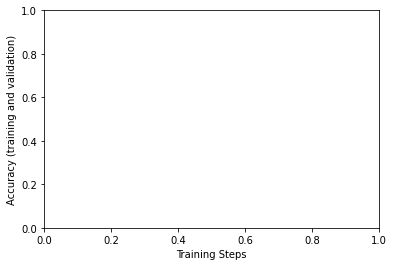

In [ ]:
# Visualize results
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])